In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from pandas import DataFrame

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits

In [3]:
class Neural_Network:
    def __init__(self, hidden_layer_sizes):
        #aka numbers of features
        self.hidden_layer_sizes = np.asarray(hidden_layer_sizes)
    def fit(self, input_data, labeled, iter_, learning_rate):
        learning_rate = learning_rate * 1/len(input_data)
        #labeled data -> matrix form
        self.expected_out = np.zeros((len(input_data), self.hidden_layer_sizes[-1]))
        for i in range(len(labeled)):
            self.expected_out[i][int(labeled[i])] = 1
        output_data = self.__forward_propagation(input_data)
        self.init_cost = self.__cost_function(output_data) #update cost
        #Optimizing
        self.opt = output_data.copy()
        for i in range(iter_):
            self.__apply_gradient(learning_rate) #gradient + back prop then update weights and biases
            self.opt = self.__re_feed(input_data) #update neurons
            cost = self.__cost_function(self.opt) #update cost
            print('Cost:', (sum(sum(cost))/2).round(2), '\tIter:', i) #print cost
        return self.opt
    def __forward_propagation(self, input_data):
        self.saved_weights = []
        self.saved_bias = []
        self.saved_raw_layer = []
        for feature in self.hidden_layer_sizes:
            #Init random weights and biases
            raw_in = input_data
            bias = self.__get_bias(input_data)
            input_data = np.c_[input_data, bias]
            weights = self.__get_weights(input_data, feature)
            #Perform matrix mul
            raw_out = input_data = input_data @ weights
            input_data = self.__activation_function(input_data)
            #Save weights, biases and raw layer (haven't pass thr activation and no biases)
            self.saved_bias.append(bias)
            self.saved_weights.append(weights)
            self.saved_raw_layer.append(raw_in)
        self.saved_raw_layer.append(raw_out)
        output_data = input_data
        return output_data
    def predict(self, input_data):
        for i in range(len(self.hidden_layer_sizes)):
            bias = self.saved_bias[i]
            weights = self.saved_weights[i]
            if bias.shape[0] > input_data.shape[0]:
                bias = np.resize(bias,(input_data.shape[0], bias.shape[1]))
            input_data = np.c_[input_data, bias]
            input_data = input_data @ weights
            input_data = self.__activation_function(input_data)
        output_data = input_data
        return output_data
    def __get_bias(self, layer):
        num_layer_rec = layer.shape[0]
        bias = np.zeros((num_layer_rec, 1))
        return bias
    def __get_weights(self, layer, num_nlayer_ft):
        num_layer_ft = layer.shape[1]
        weights = np.random.uniform(-0.25, 0.25, (num_layer_ft, num_nlayer_ft))
        return weights
    def __sigmoid(self, layer):
        return 1.0/(1.0+np.exp(-layer))
    def __activation_function(self, layer):
        ReLU = np.zeros(layer.shape, dtype=float)
        ReLU[layer>0] = layer[layer>0]
        return ReLU
    def __cost_function(self, output_data):
        #Calculate error and square error
        #Formula 1/2 sum squared error
        error = output_data - self.expected_out
        SE = np.square(error)
        #MSE
        cost = SE * 0.5
        return cost
    #Derivative
    #respect to Z (raw layer)
    def __activation_derivative_z(self, layer):
        dReLU = layer
        dReLU[dReLU>=0] = 1
        dReLU[dReLU<0] = 0
        return dReLU
    def __cost_derivative_z_L(self): #BP1 #line 30
        layer = self.saved_raw_layer[-1]
        ReLU = self.__activation_function(layer)
        dReLU = self.__activation_derivative_z(layer) #Maybe this is the fuking thing that cause the problems. Check latter
        del_L = (ReLU - self.expected_out) * dReLU
        self.del_lp1 = del_L
        return del_L
    def __cost_derivative_z_l(self, index_layer):#BP2
        del_l = ( 
                 (self.del_lp1 @ np.transpose(np.delete(self.saved_weights[index_layer],(-1),axis=0))) #delete biases's weights
                * self.__activation_derivative_z(self.saved_raw_layer[index_layer])
                )
        #update delta l+1
        self.del_lp1 = del_l
        return del_l
    #gradient descent
    def __back_propagation(self):
        network_del_l = []
        network_del_l.append(self.__cost_derivative_z_L())
        for i in reversed(range(1, len(self.saved_raw_layer)-1)):
            network_del_l.insert(0, self.__cost_derivative_z_l(i))
        return network_del_l
    def __gradient_descent(self):
        network_del_l = self.__back_propagation()
        grad_w = []
        grad_b = []
        for i in range(len(network_del_l)):
            if i == 0: aT = np.transpose(self.saved_raw_layer[i])
            else: aT = np.transpose(self.__activation_function(self.saved_raw_layer[i]))
            grad_w.append(aT@network_del_l[i])
            grad_b.append(np.mean(network_del_l[i], axis=1).reshape(-1,1))
        return grad_w, grad_b
    def __apply_gradient(self, learning_rate):
        grad_w, grad_b = self.__gradient_descent()
        for i in range(len(grad_w)):
            self.saved_weights[i][:-1,:] -= learning_rate * grad_w[i]
            self.saved_bias[i] -= learning_rate * grad_b[i]
    def __re_feed(self, input_data):
        #re-feed to update hidden and output layer
        updated_layer = []
        for i in range(len(self.hidden_layer_sizes)):
            input_data = np.c_[input_data, self.saved_bias[i]]
            input_data = input_data @ self.saved_weights[i]
            input_data = self.__activation_function(input_data)
            updated_layer.append(input_data) #append update
        self.saved_raw_layer[1:] = updated_layer #update data, exclude input layer
        return self.saved_raw_layer[-1] #return output layer

In [279]:
#X, y = make_moons(n_samples=1000, noise=0.05)
#X, y = make_circles(n_samples=1000, noise=0.04)
X, y = make_blobs(n_samples=2000,centers=3, n_features=2)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

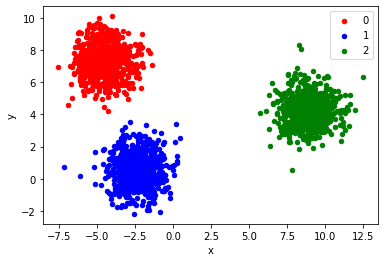

In [280]:
colors = {0:'red', 1:'blue', 2:'green', 3: 'yellow'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

In [281]:
data = df.to_numpy()
split = 0.5
TRAIN_SIZE = int(len(data)*split)
TEST_SIZE = len(data) - TRAIN_SIZE

np.random.shuffle(data)
training, test = data[:TRAIN_SIZE,:], data[TEST_SIZE:,:]

In [282]:
X, X_test = training[:,:2], test[:,:2]
y, y_test = training[:,2:].reshape(-1), test[:,2:].reshape(-1)

In [283]:
nw = Neural_Network([10,5,5, 10])

In [286]:
nw.fit(X, y, 20000, 0.0025)

Cost: 246.54 	Iter: 0
Cost: 246.49 	Iter: 1
Cost: 246.45 	Iter: 2
Cost: 246.4 	Iter: 3
Cost: 246.36 	Iter: 4
Cost: 246.31 	Iter: 5
Cost: 246.26 	Iter: 6
Cost: 246.21 	Iter: 7
Cost: 246.17 	Iter: 8
Cost: 246.12 	Iter: 9
Cost: 246.07 	Iter: 10
Cost: 246.02 	Iter: 11
Cost: 245.97 	Iter: 12
Cost: 245.92 	Iter: 13
Cost: 245.87 	Iter: 14
Cost: 245.82 	Iter: 15
Cost: 245.77 	Iter: 16
Cost: 245.72 	Iter: 17
Cost: 245.67 	Iter: 18
Cost: 245.62 	Iter: 19
Cost: 245.57 	Iter: 20
Cost: 245.51 	Iter: 21
Cost: 245.46 	Iter: 22
Cost: 245.41 	Iter: 23
Cost: 245.35 	Iter: 24
Cost: 245.3 	Iter: 25
Cost: 245.24 	Iter: 26
Cost: 245.19 	Iter: 27
Cost: 245.13 	Iter: 28
Cost: 245.08 	Iter: 29
Cost: 245.02 	Iter: 30
Cost: 244.96 	Iter: 31
Cost: 244.91 	Iter: 32
Cost: 244.85 	Iter: 33
Cost: 244.79 	Iter: 34
Cost: 244.73 	Iter: 35
Cost: 244.67 	Iter: 36
Cost: 244.61 	Iter: 37
Cost: 244.55 	Iter: 38
Cost: 244.49 	Iter: 39
Cost: 244.43 	Iter: 40
Cost: 244.37 	Iter: 41
Cost: 244.3 	Iter: 42
Cost: 244.24 	Iter: 43
C

array([[0.22992352, 0.20225328, 0.20720376, ..., 0.        , 0.        ,
        0.        ],
       [0.40486787, 0.47118351, 0.39285195, ..., 0.        , 0.        ,
        0.00218829],
       [0.11885445, 0.09891063, 0.08560376, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3267968 , 0.30367744, 0.41940442, ..., 0.        , 0.        ,
        0.        ],
       [0.28468208, 0.23896236, 0.2320615 , ..., 0.        , 0.        ,
        0.        ],
       [0.34723515, 0.32260434, 0.4456956 , ..., 0.        , 0.        ,
        0.        ]])

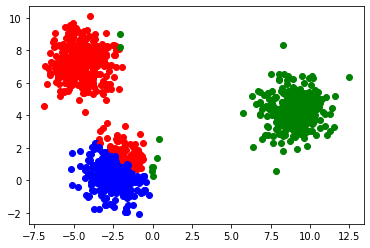

In [287]:
colors = {0:'ro', 1:'bo', 2:'go', 3: 'yo'}

r_pred = nw.predict(X_test)
f_best = []
for r in r_pred:
    f_best.append(np.argmax(r))
    
x_plot, y_plot = np.transpose(X_test)
fig, ax = plt.subplots()
for i in range(len(f_best)):
    ax.plot(x_plot[i], y_plot[i], colors[f_best[i]])

In [ ]:
test_expected_out = np.zeros((len(y_test), len(np.unique(y_test))))
for i in range(len(y_test)):
    test_expected_out[i][int(y_test[i])] = 1

In [ ]:
error = r_pred - test_expected_out
SE = np.square(error)
score = SE * 1/2

In [ ]:
sum(sum(score))/2

# Using sklearn

clf = MLPClassifier(solver='sgd', activation='relu', hidden_layer_sizes=(10,10,5), max_iter = 5000)
clf.fit(X,y)

sk_pred = clf.predict(X_test)
fig, ax = plt.subplots()
for i in range(len(sk_pred)):
    if sk_pred[i] == 0: ax.plot(X_test[i][0], X_test[i][1], 'ro')
    elif sk_pred[i] == 1: ax.plot(X_test[i][0], X_test[i][1], 'bo')
    elif sk_pred[i] == 2: ax.plot(X_test[i][0], X_test[i][1], 'go')
    else: ax.plot(X_test[i][0], X_test[i][1], 'yo')

# Digits Recognition

In [101]:
df_digits = load_digits(as_frame=True)

In [103]:
X = np.asarray(df_digits.data)
y = np.asarray(df_digits.target)

In [195]:
model = Neural_Network([100,50,30, 25])

In [238]:
model.fit(X, y, 10000, 0.0007)

Cost: 16609.98 	Iter: 0
Cost: 12075.58 	Iter: 1
Cost: 9841.58 	Iter: 2
Cost: 8471.98 	Iter: 3
Cost: 7476.63 	Iter: 4
Cost: 6665.6 	Iter: 5
Cost: 5977.27 	Iter: 6
Cost: 5385.13 	Iter: 7
Cost: 4883.3 	Iter: 8
Cost: 4462.27 	Iter: 9
Cost: 4112.43 	Iter: 10
Cost: 3821.0 	Iter: 11
Cost: 3578.88 	Iter: 12
Cost: 3377.81 	Iter: 13
Cost: 3207.18 	Iter: 14
Cost: 3060.61 	Iter: 15
Cost: 2933.6 	Iter: 16
Cost: 2822.57 	Iter: 17
Cost: 2722.33 	Iter: 18
Cost: 2630.12 	Iter: 19
Cost: 2543.51 	Iter: 20
Cost: 2462.44 	Iter: 21
Cost: 2385.09 	Iter: 22
Cost: 2311.36 	Iter: 23
Cost: 2241.79 	Iter: 24
Cost: 2175.48 	Iter: 25
Cost: 2110.38 	Iter: 26
Cost: 2047.47 	Iter: 27
Cost: 1988.37 	Iter: 28
Cost: 1934.45 	Iter: 29
Cost: 1883.58 	Iter: 30
Cost: 1835.89 	Iter: 31
Cost: 1790.96 	Iter: 32
Cost: 1747.88 	Iter: 33
Cost: 1707.47 	Iter: 34
Cost: 1669.82 	Iter: 35
Cost: 1634.46 	Iter: 36
Cost: 1601.12 	Iter: 37
Cost: 1569.78 	Iter: 38
Cost: 1540.5 	Iter: 39
Cost: 1512.97 	Iter: 40
Cost: 1486.65 	Iter: 41
Cost:

array([[1.14088551, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.41883165, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.14566933, 0.01685368, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [239]:
model_pred = model.predict(X)

In [240]:
for i in range(0,50):
    prediction = np.argmax(model_pred[i])
    answer = np.argmax(model.expected_out[i])
    #if prediction != 0:
    print('Predict:', prediction, 'Answer:', answer)

Predict: 0 Answer: 0
Predict: 1 Answer: 1
Predict: 8 Answer: 2
Predict: 3 Answer: 3
Predict: 4 Answer: 4
Predict: 0 Answer: 5
Predict: 6 Answer: 6
Predict: 7 Answer: 7
Predict: 8 Answer: 8
Predict: 9 Answer: 9
Predict: 0 Answer: 0
Predict: 1 Answer: 1
Predict: 5 Answer: 2
Predict: 3 Answer: 3
Predict: 7 Answer: 4
Predict: 5 Answer: 5
Predict: 0 Answer: 6
Predict: 1 Answer: 7
Predict: 8 Answer: 8
Predict: 2 Answer: 9
Predict: 0 Answer: 0
Predict: 1 Answer: 1
Predict: 2 Answer: 2
Predict: 3 Answer: 3
Predict: 4 Answer: 4
Predict: 5 Answer: 5
Predict: 6 Answer: 6
Predict: 4 Answer: 7
Predict: 8 Answer: 8
Predict: 2 Answer: 9
Predict: 0 Answer: 0
Predict: 2 Answer: 9
Predict: 5 Answer: 5
Predict: 5 Answer: 5
Predict: 6 Answer: 6
Predict: 5 Answer: 5
Predict: 0 Answer: 0
Predict: 0 Answer: 9
Predict: 8 Answer: 8
Predict: 9 Answer: 9
Predict: 8 Answer: 8
Predict: 4 Answer: 4
Predict: 1 Answer: 1
Predict: 7 Answer: 7
Predict: 7 Answer: 7
Predict: 3 Answer: 3
Predict: 0 Answer: 5
Predict: 1 An

Label: 9
Predict: 9


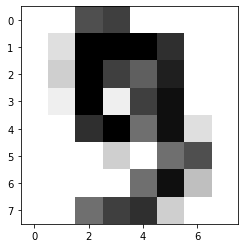

In [253]:
img_num = np.random.randint(0,400)
plt.imshow(df_digits.images[img_num], cmap = plt.cm.gray_r, interpolation = 'nearest')
print('Label:', df_digits.target[img_num])
print('Predict:', np.argmax(model_pred[img_num]))

# End